In [13]:
### Data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
# warnings.filterwarnings('ignore')
card_df = pd.read_csv('Creditcard_data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [15]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [2]:
# Amount: transaction amount, calss0: normal, class1: fraud, Time feature: drop it because it's meaningless
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [3]:
# preprocessing and train_test_split
def get_train_test_dataset(df=None):
    #preprocessing
    df_copy = get_preprocessed_df(df)
    #last column is label
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    #train_test_split with stratify parameter
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, stratify=y_target)
    #return
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)    

In [4]:
print('Label ratio in train data')
print(y_train.value_counts()/y_train.shape[0]*100)
print('Label ratio in test data')
print(y_test.value_counts()/y_test.shape[0]*100)

Label ratio in train data
0    99.827451
1     0.172549
Name: Class, dtype: float64
Label ratio in test data
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion matrix')
    print(confusion)
    print('Accuracy:{0:.4f}, Precision:{1:.4f}, Recall:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(
        accuracy, precision, recall, f1, roc_auc))

In [10]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=20000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

Confusion matrix
[[85280    15]
 [   60    88]]
Accuracy:0.9991, Precision:0.8544, Recall:0.5946, F1:0.7012, AUC:0.9804


In [11]:
# receive classifier object as a parameter, train/test dataset for learn/predict/evaluation
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)    

In [18]:
from lightgbm import LGBMClassifier

# boost_from_average = False -> if the data imbalance is significant
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=True)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

Confusion matrix
[[85237    58]
 [   98    50]]
Accuracy:0.9982, Precision:0.4630, Recall:0.3378, F1:0.3906, AUC:0.6685


In [17]:
from lightgbm import LGBMClassifier

# boost_from_average = False -> if the data imbalance is significant
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

Confusion matrix
[[85290     5]
 [   31   117]]
Accuracy:0.9996, Precision:0.9590, Recall:0.7905, F1:0.8667, AUC:0.9879


### considering data distribution (amount feature)

C:\Users\zephy\anaconda3\envs\python_ml_guide\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount', ylabel='Density'>

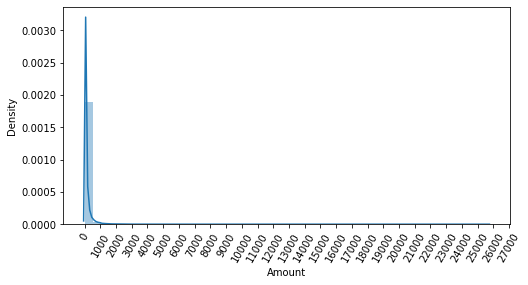

In [24]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [27]:
card_df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [71]:
# Scaling using StandardScaler
from sklearn.preprocessing import StandardScaler
#Transform to standard distribution
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy   

In [72]:
# Learning/prediction after scaling
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### Logistic regression performance ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM performance')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### Logistic regression performance ###
Confusion matrix
[[85270    25]
 [   50    98]]
Accuracy:0.9991, Precision:0.7967, Recall:0.6622, F1:0.7232, AUC:0.9684
### LightGBM performance
Confusion matrix
[[85285    10]
 [   34   114]]
Accuracy:0.9995, Precision:0.9194, Recall:0.7703, F1:0.8382, AUC:0.9652


In [73]:
X_train['Amount_Scaled'].describe()

count    199364.000000
mean         -0.000827
std           0.999895
min          -0.353229
25%          -0.331280
50%          -0.265311
75%          -0.045217
max         102.362243
Name: Amount_Scaled, dtype: float64

* Using log1p instead of StandardScaler

In [74]:
#log1p is more accurate when the input is very small
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [75]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### Logistic regression performance ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM performance')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### Logistic regression performance ###
Confusion matrix
[[85286     9]
 [   62    86]]
Accuracy:0.9992, Precision:0.9053, Recall:0.5811, F1:0.7078, AUC:0.9711
### LightGBM performance
Confusion matrix
[[85290     5]
 [   31   117]]
Accuracy:0.9996, Precision:0.9590, Recall:0.7905, F1:0.8667, AUC:0.9768


### Abnormal data removal using correlation, IQR

<AxesSubplot:>

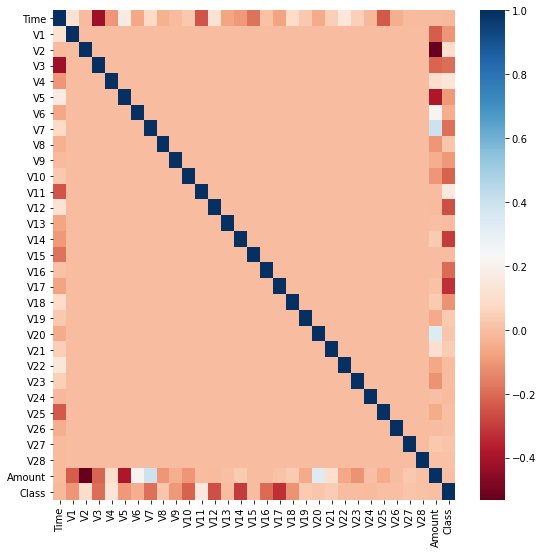

In [76]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [82]:
# V17, and V14 are the two most significant feature in correlation with Class
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR = quantile_75-quantile_25, Max = quantile_75+iqr*weight, Min = qunatile_25-iqr*weight
    iqr = quantile_75-quantile_25
    lowest_val = quantile_25-iqr*weight
    highest_val = quantile_75+iqr*weight
    # Outlier filtering
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

In [83]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('Feature V14''s outlier index', outlier_index)

Feature V14s outlier index Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [84]:
#Adding logic of filtering outlier
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True )
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### Logistic regression performance ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM performance')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### Logistic regression performance ###
Confusion matrix
[[85288     7]
 [   57    89]]
Accuracy:0.9993, Precision:0.9271, Recall:0.6096, F1:0.7355, AUC:0.9854
### LightGBM performance
Confusion matrix
[[85293     2]
 [   23   123]]
Accuracy:0.9997, Precision:0.9840, Recall:0.8425, F1:0.9077, AUC:0.9811


# SMOTE Oversampling application and model learning/prediction/evaluation

In [90]:
# SMOTE should applied only to the training data. Not to testing data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('Before SMOTE:', X_train.shape, y_train.shape)
print('After SMOTE:', X_train_over.shape, y_train_over.shape)
print('After SMOTE label distribution:\n', pd.Series(y_train_over).value_counts())

Before SMOTE: (199362, 29) (199362,)
After SMOTE: (398040, 29) (398040,)
After SMOTE label distribution:
 0    199020
1    199020
Name: Class, dtype: int64


In [91]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

Confusion matrix
[[82710  2585]
 [    7   139]]
Accuracy:0.9697, Precision:0.0510, Recall:0.9521, F1:0.0969, AUC:0.9862


In [95]:
# Precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks=(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid();
    plt.show()

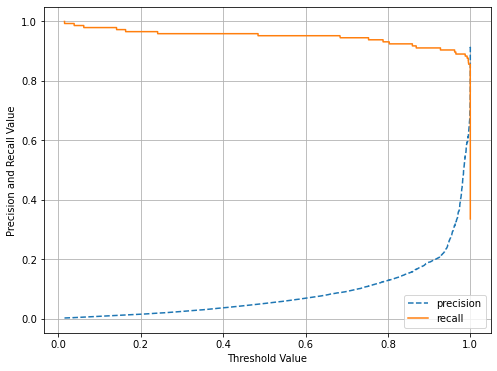

In [96]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [98]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=True)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

Confusion matrix
[[85281    14]
 [   20   126]]
Accuracy:0.9996, Precision:0.9000, Recall:0.8630, F1:0.8811, AUC:0.9864


In [97]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

Confusion matrix
[[85279    16]
 [   20   126]]
Accuracy:0.9996, Precision:0.8873, Recall:0.8630, F1:0.8750, AUC:0.9861
